# Quick Start Examples - Hierarchical Retail Data

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:

import numpy as np
import pandas as pd
import os 

# help ipython find our path
directory = os.path.dirname(os.path.abspath(''))
os.chdir(directory)

import forecastframe as ff


In [3]:
# hierarchical_data = pd.read_csv("./forecastframe/sample_data/daily/small.csv") # decided to create fake data instead of using this messy hierarchical data from kaggle

data = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv")

# create fake hierarchical retail dataset
def assign_fake_hierarchy(data, hierarchy_tuple, hierarchy_cols = ['state', 'store_id', 'category', 'sku']):
    data['hierarchy'] = [hierarchy_tuple]*len(data)
    data[hierarchy_cols] = pd.DataFrame(data['hierarchy'].tolist(), index=data.index)
    data.drop('hierarchy', axis=1, inplace=True)

    return data

stores_per_state = 5
states = ('CO', 'TX', 'CA')

categories = ('FOOD', 'APPAREL')
skus_per_dept = 10

fake_hierarchy = tuple(((state, f"{state}_{store_id}", cat, f"{cat}_{sku}") for cat in categories for sku in range(skus_per_dept) for state in states for store_id in range(stores_per_state)))

df = pd.concat([assign_fake_hierarchy(data, hierarchy_tuple) for hierarchy_tuple in fake_hierarchy])

In [4]:
df

,ds,y,state,store_id,category,sku
0,1992-01-01,146376,CA,CA_4,APPAREL,APPAREL_9
1,1992-02-01,147079,CA,CA_4,APPAREL,APPAREL_9
2,1992-03-01,159336,CA,CA_4,APPAREL,APPAREL_9
3,1992-04-01,163669,CA,CA_4,APPAREL,APPAREL_9
4,1992-05-01,170068,CA,CA_4,APPAREL,APPAREL_9
...,...,...,...,...,...,...
288,2016-01-01,400928,CA,CA_4,APPAREL,APPAREL_9
289,2016-02-01,413554,CA,CA_4,APPAREL,APPAREL_9
290,2016-03-01,460093,CA,CA_4,APPAREL,APPAREL_9
291,2016-04-01,450935,CA,CA_4,APPAREL,APPAREL_9


,ds,y,state,store_id,category,sku
0,1992-01-01,146376,CA,CA_4,APPAREL,APPAREL_9
1,1992-02-01,147079,CA,CA_4,APPAREL,APPAREL_9
2,1992-03-01,159336,CA,CA_4,APPAREL,APPAREL_9
3,1992-04-01,163669,CA,CA_4,APPAREL,APPAREL_9
4,1992-05-01,170068,CA,CA_4,APPAREL,APPAREL_9
...,...,...,...,...,...,...
288,2016-01-01,400928,CA,CA_4,APPAREL,APPAREL_9
289,2016-02-01,413554,CA,CA_4,APPAREL,APPAREL_9
290,2016-03-01,460093,CA,CA_4,APPAREL,APPAREL_9
291,2016-04-01,450935,CA,CA_4,APPAREL,APPAREL_9


In [10]:
fframe = ff.ForecastFrame(data=data, target="sales", datetime_column="datetime", hierarchy=['dept_id', 'cat_id', 'item_id', 'state_id', 'store_id'])

### Prophet

Importing plotly failed. Interactive plots will not work.


Initial log joint probability = -11.1406
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       20132.9   0.000328433       349.049      0.4844      0.4844      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       20134.2    0.00131062         341.3           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       20134.7   0.000677487        106.06           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     389       20134.9   4.33533e-08       82.4179    0.001247      0.3087      467   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance


<AxesSubplot:xlabel='datetime'>

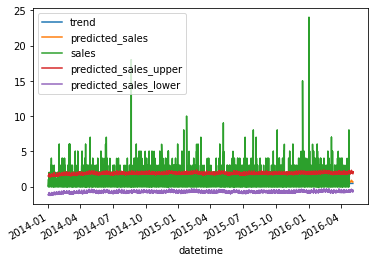

In [11]:
fframe.predict(model="prophet", future_periods=10, weekly_seasonality=True, daily_seasonality=True)


In [32]:
predictions = fframe.get_predictions()
predictions['hierarchy'] = predictions['state_id'] + "/" +  predictions['store_id'] + "/" +  predictions['cat_id'] + "/" +  predictions['dept_id'] + "/" +  predictions['item_id'] 
predictions = predictions[predictions['hierarchy'] == "CA/CA_1/FOODS/FOODS_1/FOODS_1_001"]

<AxesSubplot:xlabel='datetime'>

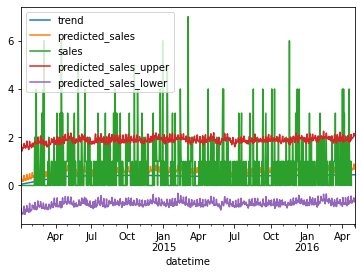

In [34]:
predictions.plot.line()

<AxesSubplot:xlabel='datetime'>

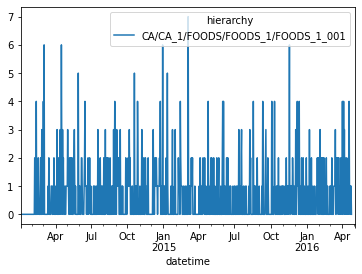

In [33]:
predictions.reset_index().pivot(index='datetime', columns="hierarchy", values='sales').plot.line()

array([<AxesSubplot:xlabel='datetime'>], dtype=object)

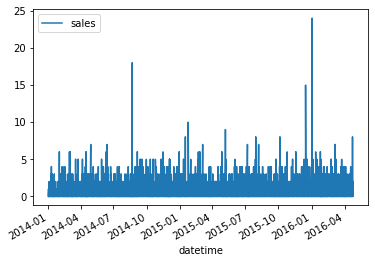

In [27]:
predictions[['sales', 'hierarchy']].plot.line(subplots=True)

In [7]:
fframe.cross_validate(folds=3, model="prophet")

In [8]:
# check that the latest round of predictions stored in the object were created using the params found in cross-validation
assert fframe.model_object.seasonality_mode == fframe.cross_validations[-1]["best_params"]["seasonality_mode"]

In [9]:
fframe.get_cross_validation_errors()

[{'In-Sample':              Actuals    Predictions  Absolute Percent Error  Absolute Error  \
  count      74.000000      74.000000               74.000000       74.000000   
  mean   198509.472973  198491.867873                0.050104    10083.191491   
  std     26907.419353   22375.499866                0.049940    10943.462357   
  min    146376.000000  155959.330002                0.000153       26.167567   
  25%    176693.500000  181545.230686                0.012393     2298.031114   
  50%    199172.500000  197959.748690                0.028598     5685.623925   
  75%    217961.000000  214673.898390                0.074053    14046.914810   
  max    271054.000000  240194.669356                0.179570    43296.390865   
  
         Squared Error  
  count   7.400000e+01  
  mean    2.198117e+08  
  std     4.325281e+08  
  min     6.847415e+02  
  25%     5.281192e+06  
  50%     3.232724e+07  
  75%     1.973184e+08  
  max     1.874577e+09  ,
  'Out-of-Sample':           

### LightGBM

<AxesSubplot:xlabel='ds'>

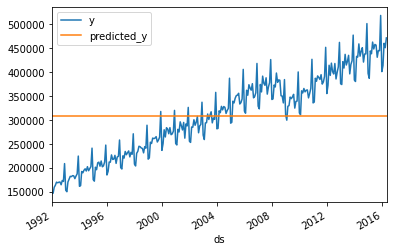

In [10]:
# Predictions are weak because our model doesn't have any features to grip on
# Note we can pass in lightgbm params as kwargs, such as learning_rate
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [11]:
# Let's add some features to help our model out
#fframe.calc_datetime_features()
fframe.lag_features(features=[fframe.target], lags=[1, 2, 3, 12]) # lagged features for 1 month ago, 2 months ago ..., 12 months ago
fframe.calc_statistical_features(features=[fframe.target], windows=[3, 6, 12], aggregations=['mean', 'std']) # 3, 6, and 12 month rolling aggregations for both mean and std
fframe.calc_ewma(fframe.target, windows=[3, 6, 12]) # 3, 6, 12 month exponential weighted moving averages

fframe.get_sample()

,y,y_lag1,y_lag2,y_lag3,y_lag12,y_mean_roll3_lag1,y_std_roll3_lag1,y_mean_roll6_lag1,y_std_roll6_lag1,y_mean_roll12_lag1,y_std_roll12_lag1,y_ewma_roll3_lag1,y_ewma_roll6_lag1,y_ewma_roll12_lag1
ds,,,,,,,,,,,,,,
1992-01-01,146376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-01,147079,146376.0,NaN,NaN,NaN,146376.0,NaN,146376.0,NaN,146376.0,NaN,NaN,NaN,NaN
1992-03-01,159336,147079.0,146376.0,NaN,NaN,147079.0,NaN,147079.0,NaN,147079.0,NaN,NaN,NaN,NaN
1992-04-01,163669,159336.0,147079.0,146376.0,NaN,159336.0,NaN,159336.0,NaN,159336.0,NaN,153982.571429,NaN,NaN
1992-05-01,170068,163669.0,159336.0,147079.0,NaN,163669.0,NaN,163669.0,NaN,163669.0,NaN,159148.666667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01,400928,518253.0,444507.0,444959.0,397252.0,518253.0,NaN,518253.0,NaN,518253.0,NaN,481216.663058,465590.525363,454208.103167
2016-02-01,413554,400928.0,518253.0,444507.0,386935.0,400928.0,NaN,400928.0,NaN,400928.0,NaN,441072.331529,447115.518116,446011.164218
2016-03-01,460093,413554.0,400928.0,518253.0,444110.0,413554.0,NaN,413554.0,NaN,413554.0,NaN,427313.165764,437526.512940,441017.754338


<AxesSubplot:xlabel='ds'>

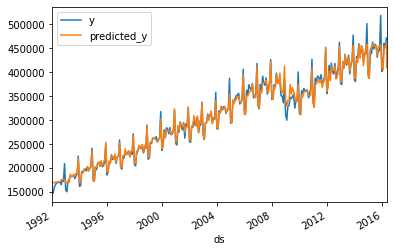

In [12]:
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [13]:
fframe.get_errors()

,Actuals,Predictions,Absolute Percent Error,Absolute Error,Squared Error
count,73.000000,73.000000,73.000000,73.000000,7.300000e+01
mean,412418.616438,364303.180273,0.115922,50254.139324,3.617877e+09
std,38360.770185,7508.214156,0.067667,33280.180547,4.392012e+09
min,335608.000000,348407.150276,0.002860,1037.306497,1.076005e+06
25%,384600.000000,357643.810446,0.064132,24418.639168,5.962699e+08
50%,414275.000000,364603.694887,0.114679,48264.983103,2.329509e+09
75%,438217.000000,369328.967625,0.159236,69779.853384,4.869228e+09
max,518253.000000,381148.353232,0.293083,151891.289292,2.307096e+10


In [14]:
fframe.cross_validate(folds=3, model="lightgbm")

Running fold 1 of 3 with train shape (74, 14) and test shape (73, 14)
Running fold 2 of 3 with train shape (147, 14) and test shape (73, 14)
Running fold 3 of 3 with train shape (220, 14) and test shape (73, 14)


In [ ]:
fframe.get_cross_validation_errors()